In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.conv_learner import *
from fastai.plots import *

In [2]:
PATH = 'data/whale_identification/'
MODEL_DIR = f'{PATH}/models'
os.makedirs(MODEL_DIR, exist_ok=True)
# os.makedirs('/cache/planet/tmp', exist_ok=True)

In [3]:
def glob_1st(path):
    return glob(f'{path}/*.*')[0]

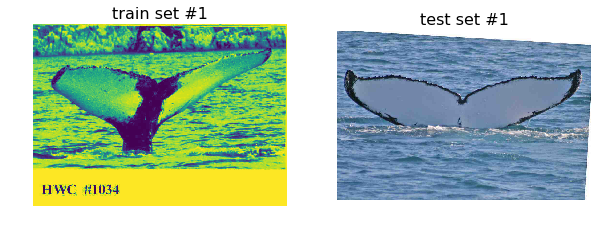

In [6]:
paths = [glob_1st(f'{PATH}/train'), glob_1st(f'{PATH}/test')]
plots_from_files(paths, titles=['train set #1', 'test set #1'])

In [ ]:
submission = pd.read_csv(f'{PATH}/')

In [10]:
def get_cv_idxs_foo(n, cv_idx=0, val_pct=0.2, seed=42):
    """ Get a list of index values for Validation set from a dataset
    
    Arguments:
        n : int, Total number of elements in the data set.
        cv_idx : int, starting index [idx_start = cv_idx*int(val_pct*n)] 
        val_pct : (int, float), validation set percentage 
        seed : seed value for RandomState
        
    Returns:
        list of indexes 
    """
    np.random.seed(seed)
    n_val = int(int(val_pct*n) / 10) * 10
    idx_start = cv_idx*n_val
    idxs = np.random.permutation(n)
    return idxs[idx_start:idx_start+n_val]

In [21]:
label_csv = f'{PATH}/train.csv'
n = len(list(open(label_csv))) - 1
val_idxs = get_cv_idxs_foo(n)

In [14]:
n, val_idxs, len(val_idxs)

(9850, array([8920, 9839, 1851, ...,  111, 2884, 8774]), 1970)

In [18]:
f_model = resnet34
bs=64

In [24]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train', label_csv, tfms=tfms,
                                        bs=bs, val_idxs=val_idxs, test_name='test', num_workers=16)

In [25]:
data = get_data(256)

In [27]:
x, y = next(iter(data.val_dl))

In [30]:
x.shape, y.shape

(torch.Size([64, 3, 256, 256]), torch.Size([64]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


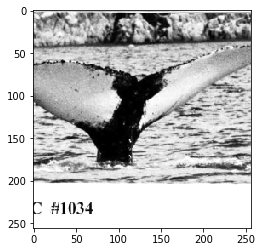

In [36]:
plt.imshow(data.val_ds.denorm(to_np(x))[0] * 1.04)

In [38]:
sz = 64
data = get_data(64)

In [39]:
data = data.resize(int(sz * 1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [72]:
len(data.classes)

4251

In [85]:
def MAP_top5(preds, targs):
#     arg_top5 = np.argsort(preds, axis=1)[:, -5:]
    p = np.exp(preds) / (np.exp(preds).sum(axis=1).reshape(-1, 1))
    p_top5 = np.sort(p, axis=1)[:, -5:]
    return p_top5.sum(axis=1).mean()

In [86]:
learner = ConvLearner.pretrained(f_model, data, metrics=MAP_top5)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\alex.huang/.torch\models\resnet34-333f7ec4.pth
100%|█████████████████████████████████████████████████████████████████| 87306240/87306240 [00:52<00:00, 1665241.84it/s]


RuntimeError: cuda runtime error (8) : invalid device function at c:\anaconda2\conda-bld\pytorch_1519496000060\work\torch\lib\thc\generic/THCTensorMath.cu:15